# Lab 7: Classifying Surnames with an RNN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/DSML4220/blob/main/lab7_rnn_for_surnames.ipynb)

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/sgeinitz/DSML4220/blob/main/lab7_rnn_for_surnames.ipynb)

We previously looked at an MLP to classify the nationality of a surname [(Misc 2 notebook)](https://github.com/sgeinitz/DSML4220/blob/main/misc02_mlp_for_surnames.ipynb), and we also looked at this solving problem with a CNN [(Lab 3 notebook)](https://github.com/sgeinitz/DSML4220/blob/main/lab3_cnn_for_surnames.ipynb). We'll now see how a recurrent neural network (RNN) performs for this task. Again, recall that: 
* there are 18 class labels the model must distinguish between and make predictions for
* the input is a single last name, which meant that we tokenized by characters (rather than by words or partial words)

Note that the code and data in this notebook is derived from the notebook [found here](https://github.com/delip/PyTorchNLPBook/blob/master/chapters/chapter_6/classifying-surnames/Chapter-6-Surname-Classification-with-RNNs.ipynb), which comes from the repository, [PyTorchNLPBook, found here](https://github.com/delip/PyTorchNLPBook).


#### Lab 7 Assignment/Task 
There is only one question/task in this lab, located at the very end of the notebook. However, as usual, you are encouraged to try experimenting with other hyperparameters and model configurations to see whether you can improve performance further. 

In [2]:
# import libraries

from argparse import Namespace
import os
import json

import numpy as np
import pandas as pd
import tqdm.auto
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


## Vocabulary, Vectorizer, Dataset

In [3]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [4]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [5]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""   
    def __init__(self, char_vocab, nationality_vocab):
        """
        Args:
            char_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname, vector_length=-1):
        """
        Args:
            title (str): the string of characters
            vector_length (int): an argument for forcing the length of index vector
        """
        indices = [self.char_vocab.begin_seq_index]
        indices.extend(self.char_vocab.lookup_token(token) 
                       for token in surname)
        indices.append(self.char_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)         
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.char_vocab.mask_index
        
        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        char_vocab = SequenceVocabulary()
        nationality_vocab = Vocabulary()

        for index, row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)

        return cls(char_vocab, nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        char_vocab = SequenceVocabulary.from_serializable(contents['char_vocab'])
        nat_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])

        return cls(char_vocab=char_vocab, nationality_vocab=nat_vocab)

    def to_serializable(self):
        return {'char_vocab': self.char_vocab.to_serializable(), 
                'nationality_vocab': self.nationality_vocab.to_serializable()}

In [6]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df 
        self._vectorizer = vectorizer

        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 
                             'val': (self.val_df, self.validation_size), 
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights
        class_counts = self.train_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))
        
    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SurnameVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's:
                features (x_data)
                label (y_target)
                feature length (x_length)
        """
        row = self._target_df.iloc[index]
        
        surname_vector, vec_length = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)
        
        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data': surname_vector, 
                'y_target': nationality_index, 
                'x_length': vec_length}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

    

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## Model

In [7]:

def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)


class ElmanRNN(nn.Module):
    """ an Elman RNN built using the RNNCell """
    def __init__(self, input_size, hidden_size, batch_first=False):
        """
        Args:
            input_size (int): size of the input vectors
            hidden_size (int): size of the hidden state vectors
            bathc_first (bool): whether the 0th dimension is batch
        """
        super(ElmanRNN, self).__init__()
        
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        
        self.batch_first = batch_first
        self.hidden_size = hidden_size

    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))

    def forward(self, x_in, initial_hidden=None, debug=False):
        """The forward pass of the ElmanRNN
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                If self.batch_first: x_in.shape = (batch, seq_size, feat_size)
                Else: x_in.shape = (seq_size, batch, feat_size)
            initial_hidden (torch.Tensor): the initial hidden state for the RNN
        Returns:
            hiddens (torch.Tensor): The outputs of the RNN at each time step. 
                If self.batch_first: hiddens.shape = (batch, seq_size, hidden_size)
                Else: hiddens.shape = (seq_size, batch, hidden_size)
        """
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
    
        hiddens = []

        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)

        hidden_t = initial_hidden
                    
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t], hidden_t)
            hiddens.append(hidden_t)
            if debug:
                print(f" At time t = {t}")
                print(f"   x_in[t] = {x_in[t]}, and x_in[t].shape = {x_in[t].shape}")
                print(f"   hidden_t = {hidden_t}, and hidden_t.shape = {hidden_t.shape}")
            
        hiddens = torch.stack(hiddens)

        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)

        return hiddens



class SurnameClassifier(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0):
        """
        Args:
            embedding_size (int): The size of the character embeddings
            num_embeddings (int): The number of characters to embed
            num_classes (int): The size of the prediction vector 
                Note: the number of nationalities
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will 
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding; 
                see torch.nn.Embedding
        """
        super(SurnameClassifier, self).__init__()

        self.emb = nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)
        self.rnn = ElmanRNN(input_size=embedding_size, 
                            hidden_size=rnn_hidden_size, batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size, out_features=rnn_hidden_size)
        self.d1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                          out_features=num_classes)
        self.d2 = nn.Dropout(p=0.1)

    def forward(self, x_in, x_lengths=None, apply_softmax=False, debug=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in.long())
        y_out = self.rnn(x_embedded, initial_hidden=None, debug=debug)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(self.d1(y_out)))
        y_out = self.fc2(self.d2(y_out))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

In [8]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

## Settings

In [9]:
args = Namespace(
    # Data and path information
    surname_csv='https://raw.githubusercontent.com/sgeinitz/DSML4220/main/data/surnames.csv',
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="./models/surnames/rnn",
    # Model hyper parameter
    char_embedding_size=150,
    rnn_hidden_size=100,
    # Training hyper parameter
    num_epochs=50, #100, # 100,
    learning_rate=0.001,
    batch_size=32,
    seed=42,
    early_stopping_criteria=5,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Using CUDA: False


In [10]:
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv, 
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(embedding_size=args.char_embedding_size, 
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

In [11]:
for key, val in vectorizer.char_vocab._idx_to_token.items():
    if key < 15 or key > 65:
        print(f"{key:2.0f} -> {val}")
    elif key == 15:
        print("...")

 0 -> <MASK>
 1 -> <UNK>
 2 -> <BEGIN>
 3 -> <END>
 4 -> T
 5 -> o
 6 -> t
 7 -> a
 8 -> h
 9 -> A
10 -> b
11 -> u
12 -> d
13 -> F
14 -> k
...
66 -> ú
67 -> à
68 -> ò
69 -> è
70 -> ó
71 -> Ś
72 -> ą
73 -> ń
74 -> á
75 -> ż
76 -> õ
77 -> í
78 -> ñ
79 -> Á


In [12]:
i = 7461 # 5031, 5032, 5035  7464 # 7461, 7464
dataset.set_split('train')
print(dataset.train_df.iloc[i])
print(f"\nobs {i} has surname: {dataset[i]}")
#print(f"\nobs {i} has label: {dataset[i]['y_nationality']}")
#print(f"\nshape of a vectorized observation is: {dataset[i]['x_surname'].shape}")

nationality          Spanish
nationality_index          6
split                  train
surname               Sierra
Name: 10665, dtype: object

obs 7461 has surname: {'x_data': array([ 2, 17, 23, 18, 15, 15,  7,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0]), 'y_target': 16, 'x_length': 8}


In [13]:
obs = dataset[i]
obs
for i in range(obs['x_length']):
    print(f"i = {obs['x_data'][i]}, character = {vectorizer.char_vocab.lookup_index(obs['x_data'][i])}")

i = 2, character = <BEGIN>
i = 17, character = S
i = 23, character = i
i = 18, character = e
i = 15, character = r
i = 15, character = r
i = 7, character = a
i = 3, character = <END>


In [14]:
# !pip install torchinfo

In [15]:
import torchinfo

torchinfo.summary(classifier, (1,19,))

# number of params is inp_size*hidden_size + hidden_size for input->hidden weight matrix
# number of params is hidden_size*hidden_size + hidden_size for hidden->hidden weight matrix


Layer (type:depth-idx)                   Output Shape              Param #
SurnameClassifier                        [1, 18]                   --
├─Embedding: 1-1                         [1, 19, 150]              12,000
├─ElmanRNN: 1-2                          [1, 19, 100]              --
│    └─RNNCell: 2-1                      [1, 100]                  25,200
│    └─RNNCell: 2-2                      [1, 100]                  (recursive)
│    └─RNNCell: 2-3                      [1, 100]                  (recursive)
│    └─RNNCell: 2-4                      [1, 100]                  (recursive)
│    └─RNNCell: 2-5                      [1, 100]                  (recursive)
│    └─RNNCell: 2-6                      [1, 100]                  (recursive)
│    └─RNNCell: 2-7                      [1, 100]                  (recursive)
│    └─RNNCell: 2-8                      [1, 100]                  (recursive)
│    └─RNNCell: 2-9                      [1, 100]                  (recursive)
│    

In [16]:
# torchsummary is not (for some reason) counting the parameters in the RNNCell, so there should be addition:
#  input_size*hidden_size + hidden_size + hidden_size*hidden_size + hidden_size 
# =    150   *   100      +     100     +     100    *   100      +    100  
# =             15100                   +             10100                      = 25200 params 
# and so the total number of parameters is actually 23918 + 25200 = 49118

# We can verify this in a more manual way here
model_parameters = filter(lambda p: p.requires_grad, classifier.parameters())
n_params_per_layer = [x.size() for x in model_parameters]
n_params_per_layer

[torch.Size([80, 150]),
 torch.Size([100, 150]),
 torch.Size([100, 100]),
 torch.Size([100]),
 torch.Size([100]),
 torch.Size([100, 100]),
 torch.Size([100]),
 torch.Size([18, 100]),
 torch.Size([18])]

In [17]:
model_parameters = filter(lambda p: p.requires_grad, classifier.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"The network has {params} trainable parameters")

The network has 49118 trainable parameters


## Training Routine

In [18]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        if loss_t >= loss_tm1:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [19]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

losses = {'train':[], 'val':[]}

train_state = make_train_state(args)

epoch_bar = tqdm.notebook.tqdm(desc='training routine', total=args.num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            losses['train'].append(loss.item())
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            losses['val'].append(loss.item())
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break
            
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/50 [00:00<?, ?it/s]

split=train:   0%|          | 0/240 [00:00<?, ?it/s]

split=val:   0%|          | 0/51 [00:00<?, ?it/s]

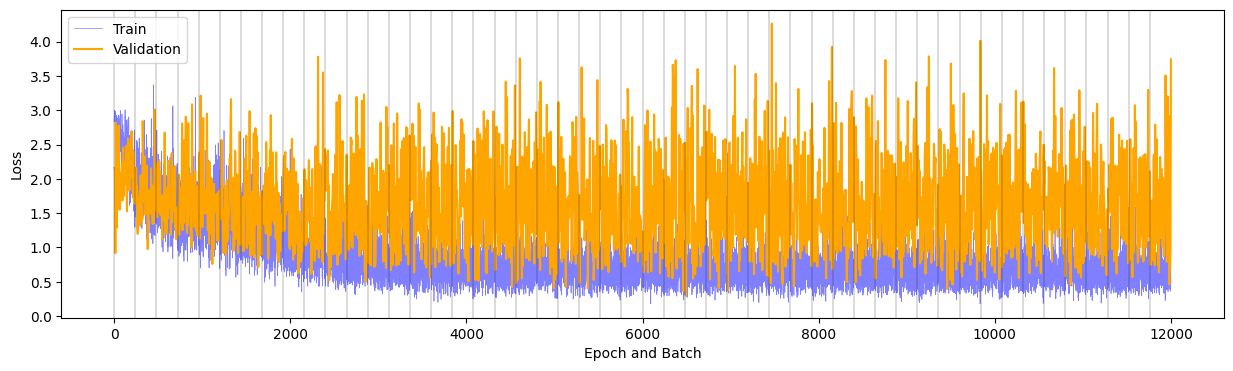

In [20]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('figure', figsize=(15,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue', lw=0.5, alpha=0.5)
plt.plot(val_ticks, losses['val'], c='orange')
for i in range(args.num_epochs):
    plt.axvline(x=i*len(losses['train'])/args.num_epochs, c='black', lw=0.2)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

In [21]:
classifier.eval() # set model to eval so that dropout is not applied, batch normalization is used rather than fit (i.e. no running mean and variance kept), etc.

SurnameClassifier(
  (emb): Embedding(80, 150, padding_idx=0)
  (rnn): ElmanRNN(
    (rnn_cell): RNNCell(150, 100)
  )
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (d1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
  (d2): Dropout(p=0.1, inplace=False)
)

In [22]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'],
                         x_lengths=batch_dict['x_length'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

/var/folders/22/hdrqs83s5z94vp_xg1v9l_180000gn/T/ipykernel_29003/2898634248.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(train_s

In [23]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 1.509907013645359;
Test Accuracy: 56.924019607843135


### Inference

In [24]:
def predict_nationality(surname, classifier, vectorizer, print_hidden=False):
    vectorized_surname, vec_length = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    vec_length = torch.tensor([vec_length], dtype=torch.int64)
    
    result = classifier(vectorized_surname, vec_length, apply_softmax=True, debug=print_hidden)
    probability_values, indices = result.max(dim=1)
    
    index = indices.item()
    prob_value = probability_values.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)

    return {'nationality': predicted_nationality, 'probability': prob_value, 'surname': surname}

In [29]:
# surname = input("Enter a surname: ")
classifier = classifier.to("cpu")
classifier.eval()
for surname in ['Geinitz', 'Thang', 'Hatton', 'Cline', 'Lassner',  'Mahamed', 'Cervantes']:
    print(predict_nationality(surname, classifier, vectorizer))

{'nationality': 'German', 'probability': 0.5446498990058899, 'surname': 'Geinitz'}
{'nationality': 'Chinese', 'probability': 0.6339532136917114, 'surname': 'Thang'}
{'nationality': 'English', 'probability': 0.41719719767570496, 'surname': 'Hatton'}
{'nationality': 'Irish', 'probability': 0.44350093603134155, 'surname': 'Cline'}
{'nationality': 'German', 'probability': 0.5186815857887268, 'surname': 'Lassner'}
{'nationality': 'Arabic', 'probability': 0.9929800629615784, 'surname': 'Mahamed'}
{'nationality': 'Portuguese', 'probability': 0.539818525314331, 'surname': 'Cervantes'}


In [ ]:
new_surname = 'Ling' #input("Enter a surname to classify: ")
prediction = predict_nationality(new_surname, classifier, vectorizer)
print("{} -> {} (p={:0.2f})".format(new_surname,
                                    prediction['nationality'],
                                    prediction['probability']))

Ling -> Chinese (p=0.66)


In [27]:
new_surname = "Ling" # Input your lastname or a lastname you want to classify""
classifier.eval()
prediction = predict_nationality(new_surname, classifier, vectorizer, print_hidden=True)

 At time t = 0
   x_in[t] = tensor([[ 0.0816,  0.0546,  1.2706,  0.8185,  0.4946, -0.6317,  0.7552, -1.0691,
          0.4414,  1.3153, -2.2860, -1.3693,  0.1431, -2.0705, -0.0485, -1.0791,
         -0.7245, -0.1492,  1.2160, -1.0398,  0.3714, -0.6966,  1.0663, -1.4366,
          0.5514,  0.3994, -0.0720,  0.1400,  0.3756,  0.6321, -1.7294, -0.9121,
          0.4434,  0.1598, -0.5936,  0.0729,  0.8628,  0.1831,  0.6802, -0.0606,
          0.6290, -0.8386, -0.5815, -0.0360,  0.7050,  1.7863, -0.0502,  1.0286,
          0.9873, -0.6870, -0.5034, -0.3183, -0.7642,  0.4051,  0.1437, -1.3300,
         -0.3246, -0.8905, -0.6481,  2.0092,  2.0051,  1.7163, -0.0865, -0.0278,
         -1.9121, -0.8909, -0.4202,  1.8749, -0.1998,  0.1595,  2.1928,  1.5737,
          0.3484,  0.7140, -0.2395,  0.6859, -0.2226, -1.2472, -1.2334,  0.3875,
         -0.5906,  0.8830, -0.3867, -0.3198,  0.6590, -0.0960, -0.1810,  0.1614,
          1.4036, -0.9496, -0.4605,  0.0680, -1.0437, -2.5162, -0.4050,  0.8574,


---

### Q: Explain what the output from the above cell is showing. Namely:

* What is the range of values of `t` shown? Explain why (and how this relates to the lastname you used). 

`In cell 9, there is a for loop that iterates from 0 to the seq_size - 1 (inclusive). seq_size is the length of the surname. t represents the index of the character in the surname. Note that in the output above t ranges from 0 to 5, which is the legnth of my surname, "ling"`

* What does each `x_in[t]` represent? What are its dimensions and why?

`x_in[t] represents the input vector at time step t (i.e character at index t). It becomes a one-hot encoded tensor/vector of length 150. 150 represents the size of the character vocabulary that the model is trained on. In the output cell above the first 5 characters of my surname "ling" are represented as one-hot encoded vectors`

* What does each `hidden_t[t]` represent? What are its dimensions and why?

`hidden_t[t] represents the hidden state of the RNN at timestep(character) t. The shape of this tensor is 1 x 100 which is the size of the hyperparameter of the RNN. The hidden state is basically the RRN memory that continously updates as the model see more characters of the surname. This tensor is used to capture the context of the surname.`

* Which part of the RNN layer output is used as input to the next (non-RNN) layer in the model? Is it `x_in` or `hidden_t`? And which value of `t` is it? 

`hidden_t is used as the input to the next layer. Note that as the model sees more characters the size of the hidden state tensor remains the same. In the output above, the hidden state tensor at t = 5 is the same as the hidden state tensor at t = 2. The hidden state tesnor is used to capture the context and the thaat is passed to the next layer of the model until we get to the end of the surname. And it is this 1x1000 context tensor that is return. The value of t is 5 in the output above, but generally it will be t = n - 1 where n is the length of the surname.`